## Data Challenge
My task:
Suppose you are a Data Scientist on the Mobile team. The team has just introduced a new UI design to the  app. The goal of the new design is to increase user engagement (measured by minutes spent on site). The team ran an A/B test to evaluate the change. Using the data, help the team understand the impact of the UI change better.

- Treatment:
New_UI design

- Evaluations:
User engagment(measured by minutes spent on site)

Data:
- t1_user_active_min.csv
- t2_user_variant.csv
- t3_user_active_min_pre.csv
- t4_user_attributes.csv

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind_from_stats
from scipy import stats
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import seaborn as sns
import math

### Import and pre-preprocess the data
1. Import the data
2. Check the data format
3. Check the anomomality of data

In [2]:
t1_user_active_min=pd.read_csv("t1_user_active_min.csv")
t2_user_variant=pd.read_csv('t2_user_variant.csv')
t3_user_active_min_pre=pd.read_csv('t3_user_active_min_pre.csv')
t4_user_attributes=pd.read_csv('t4_user_attributes.csv')

In [3]:
t1_user_active_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066402 entries, 0 to 1066401
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   uid          1066402 non-null  int64  
 1   dt           1066402 non-null  object 
 2   active_mins  1066402 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 24.4+ MB


In [4]:
t2_user_variant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uid             50000 non-null  int64 
 1   variant_number  50000 non-null  int64 
 2   dt              50000 non-null  object
 3   signup_date     50000 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


In [5]:
t3_user_active_min_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190093 entries, 0 to 1190092
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   uid          1190093 non-null  int64  
 1   dt           1190093 non-null  object 
 2   active_mins  1190093 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 27.2+ MB


In [6]:
t4_user_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   uid        50000 non-null  int64 
 1   gender     50000 non-null  object
 2   user_type  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [7]:
## Convert object datatype representing time to datetime format
t1_user_active_min['dt']=pd.to_datetime(t1_user_active_min['dt'],format='%Y-%m-%d')
t2_user_variant['signup_date']=pd.to_datetime(t2_user_variant['signup_date'],format='%Y-%m-%d')
t2_user_variant['dt']=pd.to_datetime(t2_user_variant['dt'],format='%Y-%m-%d')
t3_user_active_min_pre['dt']=pd.to_datetime(t3_user_active_min_pre['dt'],format='%Y-%m-%d')

In [8]:
##t1 contains active minutes data logged after experiment started.Thus, we wanna know the length of the experiment
t1_min_dt=t1_user_active_min['dt'].min().date()
t1_max_dt=t1_user_active_min['dt'].max().date()
duration=(t1_max_dt-t1_min_dt).days
print("The experiment duration:",t1_min_dt,'to',t1_max_dt,'it lasts',duration+1,'days')

The experiment duration: 2019-02-06 to 2019-07-05 it lasts 150 days


In [9]:
print(t2_user_variant['dt'].value_counts())
print("The experiment date is '2019-02-06'")

2019-02-06    50000
Name: dt, dtype: int64
The experiment date is '2019-02-06'


In [10]:
##Check t2 experiment group and sign_up date
t2_min_signup=t2_user_variant['signup_date'].min().date()
t2_max_signup=t2_user_variant['signup_date'].max().date()
duration2=(t2_max_signup-t2_min_signup).days
print("The signup duration:",t2_min_signup,'to',t2_max_signup,'it lasts',duration2+1,'days')
## 1970 seems odd, I need to check the singup date.

The signup duration: 1970-01-01 to 2019-02-04 it lasts 17932 days


In [11]:
## Create a new columns to filter the signup year
t2_user_variant['sign_year']=t2_user_variant['signup_date'].dt.year
t2_user_variant['sign_year'].value_counts()
##Delete data which signup year ==1970
t2_user_variant=t2_user_variant[t2_user_variant['sign_year']!=1970]
t2_user_variant.shape

(49998, 5)

In [12]:
t3_min_dt=t3_user_active_min_pre['dt'].min().date()
t3_max_dt=t3_user_active_min_pre['dt'].max().date()
duration3=(t3_max_dt-t3_min_dt).days
print("The pre-experiment duration:",t3_min_dt,'to',t3_max_dt,'it lasts',duration3+1,'days')

The pre-experiment duration: 2018-08-10 to 2019-02-05 it lasts 180 days


In [13]:
## Merge the data of t2 and t1
df_post=pd.merge(t2_user_variant,t1_user_active_min,on='uid',how='left')

In [14]:
df_post=df_post.rename(columns={'dt_x':'experiment_date','dt_y':'dt'})

In [15]:
##Active minutes have abnormal data,9999 should be the logging errors
## Users stay more than 24hour*60minutes should be errors
max_mins=24*60
print(max_mins)
df_post_new=df_post[df_post['active_mins']<=max_mins]
print("Delete units:",df_post[df_post['active_mins']>max_mins].shape[0])
print("Remaining units:",df_post_new.shape[0])

1440
Delete units: 172
Remaining units: 1066170


## Question 2:  Experiment Analysis
- Unit of diversion
User-id
- Evaluation metrics
 - User engagment 
=total minutes of users spending on a site / number of users 
 - Total minutes per user in each group (number of data points in each group = number of users in that group)
- Null hypothesize
With the launch of new UI desgin, minutes of one user spending on the site did not increase significantly
- Alternative hypothesize
With the launch of new UI desgin, minutes of one user spending on the site increase significantly

In [16]:
df_post_new.isnull().sum()
## There is no missing values in the df_post_new

uid                0
variant_number     0
experiment_date    0
signup_date        0
sign_year          0
dt                 0
active_mins        0
dtype: int64

In [17]:
df_post_new['uid'].nunique()
## there is 46631 uniuqe user in the experiment

46631

In [18]:
df_post_v1=df_post_new.groupby(['uid','variant_number'],as_index=False).agg({
                                                      'active_mins':'sum'})

In [19]:
df_post_v1.groupby(['variant_number'],as_index=False).active_mins.agg({'mean','std','var','median','count'})

,mean,std,var,count,median
variant_number,,,,,
0,458.238142,1653.489681,2.734028e+06,37423,52.0
1,458.402476,1680.571091,2.824319e+06,9208,71.0


It seems that there is no difference in mean between control group and treatment group

/Users/yanzhenlei/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yanzhenlei/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


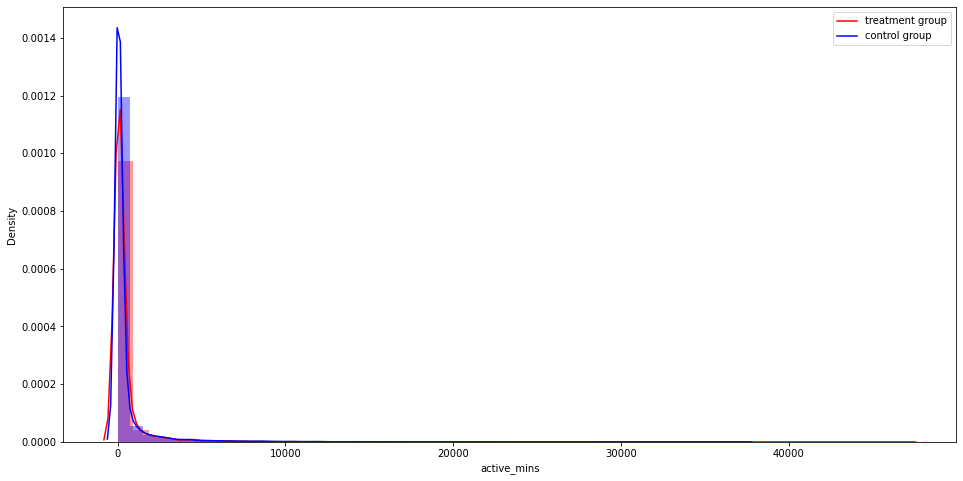

In [24]:
plt.figsize=(16,8)
treat=df_post_v1[df_post_v1['variant_number']==1]
control=df_post_v1[df_post_v1['variant_number']==0]
fig,ax=plt.subplots(figsize=(16,8))
sns.distplot(treat['active_mins'],hist=True,color='r',label='treatment')
sns.distplot(control['active_mins'],hist=True,color='b',label='control')
plt.legend(['treatment group','control group'])
plt.show()

### T-Test Result

In [25]:
mean_1=df_post_v1[df_post_v1['variant_number']==1].active_mins.mean()
std_1=df_post_v1[df_post_v1['variant_number']==1].active_mins.std()
count_1=df_post_v1[df_post_v1['variant_number']==1].active_mins.count()
mean_0=df_post_v1[df_post_v1['variant_number']==0].active_mins.mean()
std_0=df_post_v1[df_post_v1['variant_number']==0].active_mins.std()
count_0=df_post_v1[df_post_v1['variant_number']==0].active_mins.count()

In [26]:
##Ttest
ttest_ind_from_stats(mean1=mean_1,std1=std_1,nobs1=count_1,
                     mean2=mean_0,std2=std_0,nobs2=count_0, equal_var=False)

Ttest_indResult(statistic=0.008432565461448143, pvalue=0.9932719867798543)

The pvalue is high(0.9932), which is greater than 5% thus we reject the null hypothesize and accepte the alternative hypothesize that the users engagmenet increase significantly.

In [27]:
def calc_CI(mean_1,std_1,nobs1,mean_0,std_0,nobs0,CI_interval):
    se = np.sqrt((std_1*std_1)/nobs1 +(std_0*std_0)/nobs0)
    mean_diff=mean_1-mean_0
    qt=stats.norm.isf((1-CI_interval)/2)
    lower=mean_diff -qt*se
    upper=mean_diff +qt*se
    return(lower,upper)
CI=calc_CI(mean_1,std_1,count_1,mean_0,std_0,count_0,0.95)
CI

(-38.031433446797, 38.36010102447222)

- 0 include in the confidence interval so the result is not significant.
- Although the result shows that the ttest is not significant, we can not ensure that both groups remain same performance before the experiment. Maybe time effect change their moving pattern. For example, the duration per user in treatment group are lower than the duration per user in control group before the experiment. Thus, we need to conduct further research

## Question 3: Before and After comparsion

### Difference in difference methods
Difference in differences(DID) is a statistical technique that attempts to mimic an experimental research design using observational study data, by studying the differential effect of a treatment on a 'treatment group' versus a 'control group' in a natural experiment. In the first period, none of the groups is exposed to treatment. In the second period, only one of the groups gets exposed to treatment, but not the other. 

DID calculates the effect of a treatment on an outcome by comparing the average change over time in the outcome variable for the treatment group to the average change over time for the control group. Although it is intended to mitigate the effects of extraneous factors and selection bias, depending on how the treatment group is chosen, this method may still be subject to certain biases.

In order to mimic the experiment, we should choose two comparable groups. The data before and after experiment might contains people with different signup date and different activity date.
Because our metrics is the total minutes per user with the time frame so it should be same time frame. Here I filter the users:
1. The time frame for experiment duration is 150 days before and after the experiment, thus 300 days. 
2. The users' activity shoule be within the timeframe.
3. The users signup date should before the timeframe. Thus, no new users would just in the two time period and it might affect the 

With this filterations and merge the before and after data with the same uid, I can extract the groups of people who went through the total time frame and evalute that whether the experiment improve the duration on site per user.
1. Merge the data with same uid
2. Calculate the difference in duration per users 
3. Perform T-Test and Calculate the Confidnece interval
4. Draw a conclusion

### Filter the groups

In [73]:
df_pre=pd.merge(t2_user_variant,t3_user_active_min_pre,on='uid',how='left')
df_pre.shape

(1190320, 7)

In [75]:
df_pre=df_pre.rename(columns={'dt_x':'experiment_dt',
                                   'dt_y':'dt'})

In [76]:
#delete the odd number
print('It deletes',df_pre[df_pre['active_mins']>max_mins].shape[0])
df_pre=df_pre[df_pre['active_mins']<=max_mins]

It deletes 166


In [77]:
df_pre['variant_number'].value_counts()

0    989252
1    200599
Name: variant_number, dtype: int64

Because we are comparing the data before experiment and after so the time duration should be the same. Also, it should be the same group of people, ruling out the influence of new-signup users.

In [78]:
early_dt=t3_max_dt-timedelta(days=149)
late_dt=t1_max_dt
print(early_dt)
print(late_dt)

2018-09-09
2019-07-05


So the time frame should be '2018-09-09' to '2019-07-05'

In [38]:
## Keep the activity after '2018-9-9'
df_pre=df_pre[df_pre['dt']>='2018-09-09']

In [88]:
## Keep data whose singup date <='2018-09-09'
df_post_remain=df_post_new[df_post_new['signup_date']<'2018-09-09']
df_post_remove=df_post_new[df_post_new['signup_date']>='2018-09-09']
print("df_post removes:",df_post_remove.shape[0])
print("df_post remains:",df_post_remain.shape[0])
df_pre_remain=df_pre[df_pre['signup_date']<'2018-09-09']
df_pre_remove=df_pre[df_pre['signup_date']>='2018-09-09']
print("df_pre removes:",df_pre_remove.shape[0])
print("df_pre remains:",df_pre_remain.shape[0])

df_post removes: 153052
df_post remains: 913118
df_pre removes: 101830
df_pre remains: 1088021


In [90]:
uids=pd.merge(df_post_remain['uid'],df_pre_remain['uid'],on='uid',how='inner')
print(uids.nunique())
## There are 36k users left

uid    35226
dtype: int64


In [91]:
## keep the same group of users
df_post_v2=df_post_remain[df_post_remain.uid.isin(uids.uid)&df_post_remain.sign_year!=1970]
print(df_post_v2.shape)
df_pre_v2=df_pre_remain[df_pre_remain.uid.isin(uids.uid)&df_pre_remain.sign_year!=1970]
print(df_pre_v2.shape)

(913118, 7)
(1088021, 7)


In [92]:
print(df_pre_v2.columns)
print(df_post_v2.columns)

Index(['uid', 'variant_number', 'experiment_dt', 'signup_date', 'sign_year',
       'dt', 'active_mins'],
      dtype='object')
Index(['uid', 'variant_number', 'experiment_date', 'signup_date', 'sign_year',
       'dt', 'active_mins'],
      dtype='object')


In [275]:
df_post_vn=df_post_v2.groupby(['variant_number','uid'],as_index=False).agg({'active_mins':'sum'})
df_pre_vn=df_pre_v2.groupby(['variant_number','uid'],as_index=False).agg({'active_mins':'sum'})

In [296]:
df_post_v=df_post_v2.groupby(['variant_number','dt'],as_index=False).agg({'active_mins':'mean'})
df_pre_v=df_pre_v2.groupby(['variant_number','dt'],as_index=False).agg({'active_mins':'mean'})

In [297]:
total_v=df_post_v.append(df_pre_v)

In [298]:
total_v=total_v.set_index('dt')

In [299]:
index=total_v.index
print(index)

DatetimeIndex(['2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15',
               ...
               '2019-01-27', '2019-01-28', '2019-01-29', '2019-01-30',
               '2019-01-31', '2019-02-01', '2019-02-02', '2019-02-03',
               '2019-02-04', '2019-02-05'],
              dtype='datetime64[ns]', name='dt', length=660, freq=None)


In [300]:
control=total_v[total_v['variant_number']==0]['active_mins']
treat=total_v[total_v['variant_number']==1]['active_mins']
a1=pd.DataFrame({'control_group':control,'treat_group':treat},index=index)

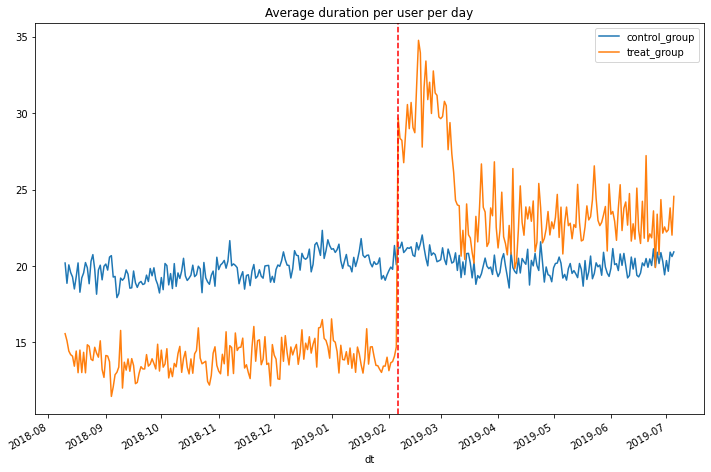

In [306]:
a1.plot(figsize=(12,8))
plt.axvline(x='2019-02-06',ls='--',c='red')
plt.title('Average duration per user per day')
plt.show()

In [94]:
df_post_vn.groupby(['variant_number'],as_index=False).active_mins.agg({'mean','std','var','median','count'})

,mean,std,var,count,median
variant_number,,,,,
0,539.438216,1812.361414,3.284654e+06,28438,68.0
1,548.661233,1828.184699,3.342259e+06,6810,92.0


In [95]:
df_pre_vn.groupby(['variant_number'],as_index=False).active_mins.agg({'mean','std','var','median','count'})

,mean,std,var,count,median
variant_number,,,,,
0,614.829891,2087.267719,4.356687e+06,29193,83.0
1,364.805417,1255.363618,1.575938e+06,7015,71.0


From the above results,before the experiment , the total minutes per users in treatment group is way less than those in control group while after the experiment,the total minutes per users in treatment group is slightly higher than those in control group. Maybe variances in groups played a role and Thus we use the DID methods to examinate whether the difference over time is significant.

### Difference in difference methods

In [313]:
total_v1=pd.merge(df_post_vn,df_pre_vn,on=['uid','variant_number'],how='inner')

In [314]:
total_v1.shape

(35226, 4)

In [315]:
total_v1.isnull().sum()

variant_number    0
uid               0
active_mins_x     0
active_mins_y     0
dtype: int64

In [316]:
total_v1.columns

Index(['variant_number', 'uid', 'active_mins_x', 'active_mins_y'], dtype='object')

In [317]:
total_v1['diff']=total_v1['active_mins_x']-total_v1['active_mins_y']

In [318]:
control=total_v1[(total_v1.variant_number==0)]
treat=total_v1[(total_v1.variant_number==1)]
    
mean1_1=treat['diff'].mean()
mean0_1=control['diff'].mean()
std1_1=treat['diff'].std()
std0_1=control['diff'].std()
count1_1=treat['diff'].count()
count0_1=control['diff'].count()
    
ttest_ind_from_stats(mean1=mean1_1,std1=std1_1,nobs1=count1_1,
                     mean2=mean0_1,std2=std0_1,nobs2=count0_1, equal_var=False)

Ttest_indResult(statistic=18.517467441085433, pvalue=2.5313514025385594e-75)

The pvalue is less than 5% thus we reject the null hypothesize and accepte the alternative hypothesize that the duration of the same group increase significantly.

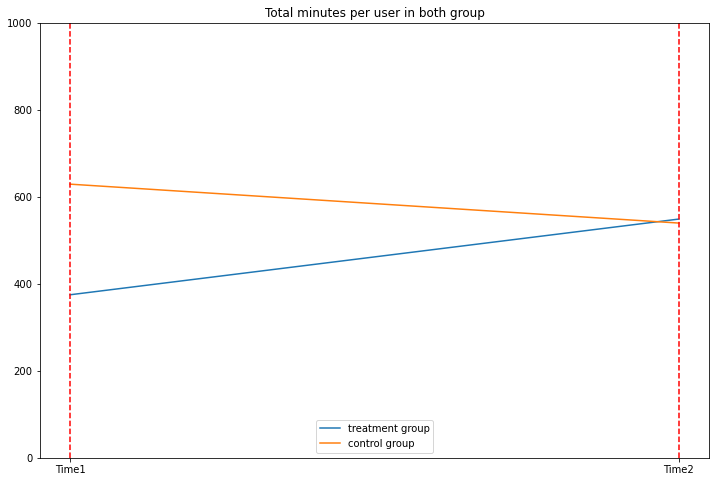

In [322]:
f, (ax1) = plt.subplots(1,figsize=(12,8))
x=['Time1','Time2']
y1=[treat['active_mins_y'].mean(),treat['active_mins_x'].mean()]
y2=[control['active_mins_y'].mean(),control['active_mins_x'].mean()]
ax1.plot(x,y1,y2)
ax1.axvline(x='Time1',color='r',ls='--')
ax1.axvline(x='Time2',color='r',ls='--')
ax1.set_ylim(0,1000)
ax1.set_title('Total minutes per user in both group')
ax1.legend(['treatment group','control group'])
plt.show()

In [312]:
CI=calc_CI(mean1_1,std1_1,count1_1,
           mean0_1,std0_1,count0_1,0.95)
CI

(235.65337337266325, 291.44344170729573)

0 doesn't include in the confidence interval so the result is significant.

## Question 4

In [196]:
df_post_v1

,uid,variant_number,active_mins
0,0,0,43.0
1,1,0,15205.0
2,2,0,17.0
3,3,0,77.0
4,4,0,39.0
...,...,...,...
46626,49995,1,95.0
46627,49996,1,156.0
46628,49997,1,379.0
46629,49998,1,597.0


In [197]:
total_v0=pd.merge(df_post_v1,t4_user_attributes,on='uid',how='left')

In [198]:
total_v0.groupby(['user_type','variant_number']).active_mins.agg({'mean','count','median','std'})

mean          std  median  count
user_type   variant_number                                         
contributor 0               4309.835346  5907.027729  2173.0    911
            1               4708.031496  7266.707254  1808.0    127
new_user    0                 28.685209   150.615233     8.0   2373
            1                 52.955446   207.580212    15.0    808
non_reader  0                104.850514   334.740354    39.0  27454
            1                164.348638   442.733561    61.0   7013
reader      0               1537.135378  2514.704902   603.0   6685
            1               1926.734127  3111.833859   829.5   1260

Text(0.5, 1.0, 'Difference in different user_type')

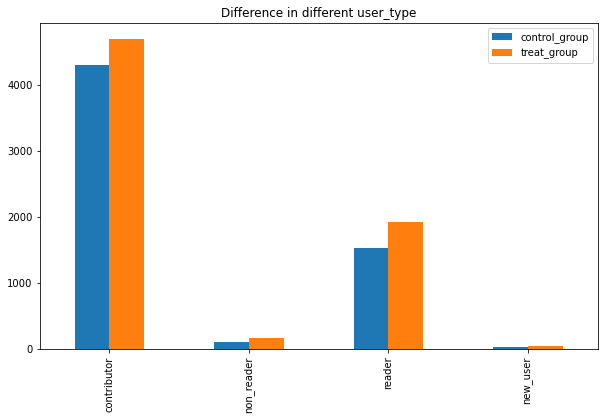

In [245]:
total_u=total_v0.groupby(['user_type','variant_number'],as_index=False).agg({'active_mins':'mean'})
total_u=total_u.set_index('user_type')
control=total_u[total_u['variant_number']==0]['active_mins']
treat=total_u[total_u['variant_number']==1]['active_mins']
index=list(set(total_u.index))
total_u2=pd.DataFrame({'control_group':control,'treat_group':treat},index=index)
total_u2.plot.bar(figsize=(10,6))
plt.title('Difference in different user_type')

Text(0.5, 1.0, 'Difference in different gender')

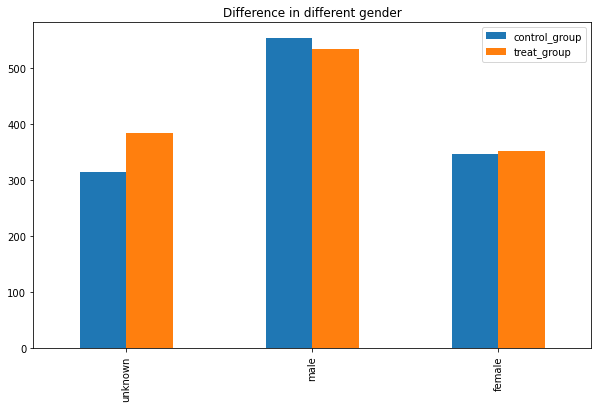

In [244]:
total_u=total_v0.groupby(['gender','variant_number'],as_index=False).agg({'active_mins':'mean'})
total_u=total_u.set_index('gender')
control=total_u[total_u['variant_number']==0]['active_mins']
treat=total_u[total_u['variant_number']==1]['active_mins']
index=list(set(total_u.index))
total_u2=pd.DataFrame({'control_group':control,'treat_group':treat},index=index)
total_u2.plot.bar(figsize=(10,6))
plt.title('Difference in different gender')

### T-test for segments

In [261]:
pd.crosstab(total_v0['variant_number'],total_v0['gender']).apply(lambda r:r/r.sum(),axis=1)

gender,female,male,unknown
variant_number,,,
0,0.286856,0.561286,0.151858
1,0.283666,0.557776,0.158558


The distribution of gender is balanced

In [262]:
pd.crosstab(total_v0['variant_number'],total_v0['user_type']).apply(lambda r:r/r.sum(),axis=1)

user_type,contributor,new_user,non_reader,reader
variant_number,,,,
0,0.024343,0.06341,0.733613,0.178633
1,0.013792,0.08775,0.761620,0.136838


The distribution of user_type is not balanced. The portotion of contributor in control group is higher than that in treatment group. 

In [263]:
pd.crosstab(total_v0['gender'],total_v0['user_type']).apply(lambda r:r/r.sum(),axis=1)

user_type,contributor,new_user,non_reader,reader
gender,,,,
female,0.018656,0.077770,0.742789,0.160785
male,0.025783,0.057725,0.731189,0.185303
unknown,0.016100,0.088758,0.761445,0.133697


The distribution between gender and usertype is balanced.

In [246]:
utype=total_v0['user_type'].unique().tolist()
for u in utype:
    control=total_v0[(total_v0.variant_number==0)&(total_v0.user_type==u)]
    treat=total_v0[(total_v0.variant_number==1)&(total_v0.user_type==u)]
    
    mean1_1=treat['active_mins'].mean()
    mean1_0=control['active_mins'].mean()
    std1_1=treat['active_mins'].std()
    std1_0=control['active_mins'].std()
    count1_1=treat['active_mins'].count()
    count1_0=control['active_mins'].count()
    
    result=ttest_ind_from_stats(mean1=mean1_1,std1=std1_1,nobs1=count1_1,
                     mean2=mean1_0,std2=std1_0,nobs2=count1_0, equal_var=False)
    print(u,'--->',result)

non_reader ---> Ttest_indResult(statistic=10.512731265241568, pvalue=1.0568832512432239e-25)
reader ---> Ttest_indResult(statistic=4.1935306650967945, pvalue=2.8985019711630837e-05)
new_user ---> Ttest_indResult(statistic=3.0604779571128873, pvalue=0.0022629092777879177)
contributor ---> Ttest_indResult(statistic=0.5909167782289572, pvalue=0.5554648962086736)


Only contributor p values are larger than 0.05, the other three types are significant

In [247]:
gtype=total_v0['gender'].unique().tolist()
for g in gtype:
    control=total_v0[(total_v0.variant_number==0)&(total_v0.gender==g)]
    treat=total_v0[(total_v0.variant_number==1)&(total_v0.gender==g)]
    
    mean1_1=treat['active_mins'].mean()
    mean1_0=control['active_mins'].mean()
    std1_1=treat['active_mins'].std()
    std1_0=control['active_mins'].std()
    count1_1=treat['active_mins'].count()
    count1_0=control['active_mins'].count()
    
    result=ttest_ind_from_stats(mean1=mean1_1,std1=std1_1,nobs1=count1_1,
                     mean2=mean1_0,std2=std1_0,nobs2=count1_0, equal_var=False)
    print(g,'--->',result)

male ---> Ttest_indResult(statistic=-0.7086394938772687, pvalue=0.47856936932472216)
female ---> Ttest_indResult(statistic=0.23711214572996966, pvalue=0.812581798566387)
unknown ---> Ttest_indResult(statistic=1.6286397378739212, pvalue=0.10354618954377928)


Three types of gender are not significant

### Dive down the segments: rule out the contributors

In [248]:
##delete the user_type which is not significant
clean_1=total_v0[total_v0['user_type']!='contributor']

In [249]:
mean_1=clean_1[clean_1['variant_number']==1].active_mins.mean()
std_1=clean_1[clean_1['variant_number']==1].active_mins.std()
count_1=clean_1[clean_1['variant_number']==1].active_mins.count()
mean_0=clean_1[clean_1['variant_number']==0].active_mins.mean()
std_0=clean_1[clean_1['variant_number']==0].active_mins.std()
count_0=clean_1[clean_1['variant_number']==0].active_mins.count()
##Ttest
ttest_ind_from_stats(mean1=mean_1,std1=std_1,nobs1=count_1,
                     mean2=mean_0,std2=std_0,nobs2=count_0, equal_var=False)

Ttest_indResult(statistic=2.334115438447026, pvalue=0.01960475130926271)

If we rule out the type of contributor, thus the p value would be less than 0.05, and it is sinificant. Thus, maybe we can push the UI design to specific user type('non_reader','reader','reader')

### Difference in difference for different segment

In [264]:
total=pd.merge(total_v1,t4_user_attributes,on=['uid'],how='inner')

In [265]:
total

,variant_number,uid,active_mins_x,active_mins_y,diff,gender,user_type
0,0,1,15205.0,19158.0,-3953.0,male,reader
1,0,3,77.0,108.0,-31.0,male,non_reader
2,0,4,39.0,66.0,-27.0,male,non_reader
3,0,5,174.0,21.0,153.0,female,non_reader
4,0,6,26.0,12.0,14.0,female,non_reader
...,...,...,...,...,...,...,...
35221,1,49993,129.0,197.0,-68.0,male,non_reader
35222,1,49994,79.0,15.0,64.0,female,non_reader
35223,1,49996,156.0,243.0,-87.0,male,non_reader
35224,1,49998,597.0,124.0,473.0,male,non_reader


In [266]:
total=total.rename(columns={'active_mins_x':'p_active_mins',
                            'active_mins_y':'b_active_mins'})

In [267]:
total

,variant_number,uid,p_active_mins,b_active_mins,diff,gender,user_type
0,0,1,15205.0,19158.0,-3953.0,male,reader
1,0,3,77.0,108.0,-31.0,male,non_reader
2,0,4,39.0,66.0,-27.0,male,non_reader
3,0,5,174.0,21.0,153.0,female,non_reader
4,0,6,26.0,12.0,14.0,female,non_reader
...,...,...,...,...,...,...,...
35221,1,49993,129.0,197.0,-68.0,male,non_reader
35222,1,49994,79.0,15.0,64.0,female,non_reader
35223,1,49996,156.0,243.0,-87.0,male,non_reader
35224,1,49998,597.0,124.0,473.0,male,non_reader


In [269]:
utype=total['user_type'].unique().tolist()
for u in utype:
    control=total[(total.variant_number==0)&(total.user_type==u)]
    treat=total[(total.variant_number==1)&(total.user_type==u)]
    
    mean1_1=treat['diff'].mean()
    mean1_0=control['diff'].mean()
    std1_1=treat['diff'].std()
    std1_0=control['diff'].std()
    count1_1=treat['diff'].count()
    count1_0=control['diff'].count()
    
    result=ttest_ind_from_stats(mean1=mean1_1,std1=std1_1,nobs1=count1_1,
                     mean2=mean1_0,std2=std1_0,nobs2=count1_0, equal_var=False)
    print(u,'--->',result)

reader ---> Ttest_indResult(statistic=14.794557927587649, pvalue=3.833908373606965e-46)
non_reader ---> Ttest_indResult(statistic=12.179658151461627, pvalue=8.951419865424315e-34)
contributor ---> Ttest_indResult(statistic=4.748764186255324, pvalue=5.064179841331389e-06)


In [270]:
gender=total['gender'].unique().tolist()
for g in gender:
    control=total[(total.variant_number==0)&(total.gender==g)]
    treat=total[(total.variant_number==1)&(total.gender==g)]
    
    mean1_1=treat['diff'].mean()
    mean1_0=control['diff'].mean()
    std1_1=treat['diff'].std()
    std1_0=control['diff'].std()
    count1_1=treat['diff'].count()
    count1_0=control['diff'].count()
    
    result=ttest_ind_from_stats(mean1=mean1_1,std1=std1_1,nobs1=count1_1,
                     mean2=mean1_0,std2=std1_0,nobs2=count1_0, equal_var=False)
    print(g,'--->',result)

male ---> Ttest_indResult(statistic=14.014820531911841, pvalue=6.817909455245259e-44)
female ---> Ttest_indResult(statistic=10.047919497165974, pvalue=2.0477146079946833e-23)
unknown ---> Ttest_indResult(statistic=8.088976875085036, pvalue=1.0807751186242091e-15)


Three user types and three types of gender are all significant

In [271]:
for u in utype:
    control=total[(total.variant_number==0)&(total.user_type==u)]
    treat=total[(total.variant_number==1)&(total.user_type==u)]
    
    mean1_1=treat['diff'].mean()
    mean1_0=control['diff'].mean()
    std1_1=treat['diff'].std()
    std1_0=control['diff'].std()
    count1_1=treat['diff'].count()
    count1_0=control['diff'].count()
    
    
    CI=calc_CI(mean1_1,std1_1,count1_1,mean0_1,std0_1,count0_1,0.95)
    print(u,'confidence interval--->',CI)

reader confidence interval---> (625.8366096945716, 858.7060359486176)
non_reader confidence interval---> (133.30429639523686, 165.84276015552007)
contributor confidence interval---> (441.6421569448669, 2030.1869936081096)


In [272]:
for g in gender:
    control=total[(total.variant_number==0)&(total.gender==g)]
    treat=total[(total.variant_number==1)&(total.gender==g)]
    
    mean1_1=treat['diff'].mean()
    mean1_0=control['diff'].mean()
    std1_1=treat['diff'].std()
    std1_0=control['diff'].std()
    count1_1=treat['diff'].count()
    count1_0=control['diff'].count()
    
    
    CI=calc_CI(mean1_1,std1_1,count1_1,mean0_1,std0_1,count0_1,0.95)
    print(g,'confidence interval--->',CI)

male confidence interval---> (258.80140507459055, 338.52942359373355)
female confidence interval---> (171.7182287043158, 241.80910652740957)
unknown confidence interval---> (173.76871208105666, 281.3827196023427)


## Summary
To analysis the new UI effect, I chose the total minutes per user in each group as a unit of analysis. After cleaning up the data, the T-Test result is not significant but we need to conduct further research to conclude. After selecting the same group of users, the difference in different methods manifests that the duration per user in the treatment group is way less than that in the control group. With the launch of the new UI design, the difference between the duration of users in the treatment group and users in the control group shrinks. The T-test proves that the difference is significant so we can claim that the new UI design played a positive role and we should launch the UI design. To further support our conclusion, we dive into segments of the data. In terms of user types, in addition to the contributor, the data for the other three types of users are significant. Combined with the DID methods, the duration for users of all kinds of user types and genders increased significantly. 